In [38]:
from fastbook import *
from fastai.vision.widgets import *

In [39]:
key = os.environ.get('AZURE_SEARCH_KEY', 'a5c7bba46f7f43d4aee6ca170d36435b')
print(key)

a5c7bba46f7f43d4aee6ca170d36435b


In [40]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [41]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [42]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

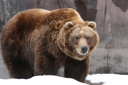

In [43]:
im = Image.open(dest)
im.to_thumb(128, 128)

This seems to have worked nicely, so let's use fastai's download_images to download all the URLs for each of our search terms. We'll put each in a separate folder:



In [44]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
print(bear_types)

('grizzly', 'black', 'teddy')


In [45]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [46]:
fns = get_image_files(path)
fns

(#302) [Path('bears/grizzly/58f2bbf7-8f0c-47a6-9a19-f0cb392d6a64.jpg'),Path('bears/grizzly/b863dd7e-39a7-4a9d-b9cd-0b0e6b8d738f.jpg'),Path('bears/grizzly/a9626eed-8984-411d-b359-4fb7688c7886.jpg'),Path('bears/grizzly/1889c548-812a-4ef3-9e30-7ba4e2cca586.jpg'),Path('bears/grizzly/e596fb00-607b-463e-8956-93a697d12544.jpg'),Path('bears/grizzly/5e8656e4-e5cf-4dce-8b75-aa9b33eef5d2.jpg'),Path('bears/grizzly/9547817b-c581-4882-9785-5531d029bf7a.jpg'),Path('bears/grizzly/12f581b4-e8d2-443a-8bc1-99cc32a0b37a.jpg'),Path('bears/grizzly/1b36dbc9-af9e-4cc8-a2f4-7eb1cf9d3e21.jpg'),Path('bears/grizzly/f1985d48-1756-4e59-8f88-b225cbab0117.jpg')...]

In [47]:
failed = verify_images(fns)
failed

(#0) []

In [48]:
failed.map(Path.unlink);

In [49]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [50]:
dls = bears.dataloaders(path)


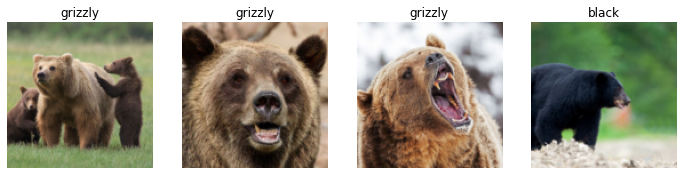

In [51]:
dls.valid.show_batch(max_n=4, nrows=1)

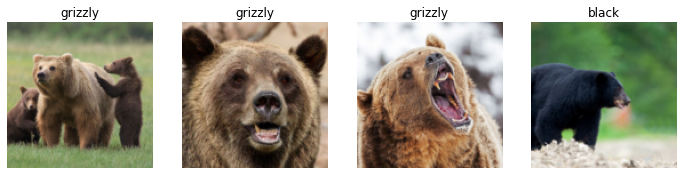

In [52]:
dls.valid.show_batch(max_n=4, nrows=1)

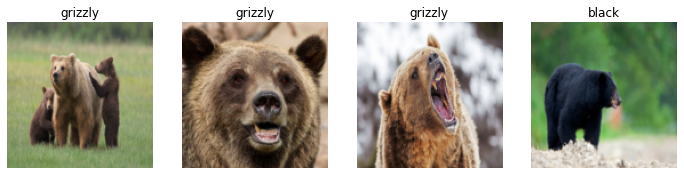

In [53]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

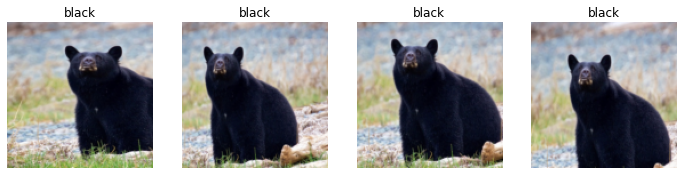

In [54]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


In [55]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [56]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.626936,1.773429,0.500000,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.805500,0.428882,0.150000,00:28
1,0.577535,0.160187,0.050000,00:28
2,0.442598,0.140908,0.050000,00:29
3,0.340041,0.134714,0.050000,00:28


In [57]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [58]:
learn.export()

In [59]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [60]:
learn_inf = load_learner(path/'export.pkl')

In [61]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([3.5765e-08, 9.9979e-01, 2.1448e-04]))

In [62]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

# Creating a Notebook App from the Model

In [63]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [64]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [65]:
img = PILImage.create(btn_upload.data[-1])

In [66]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [67]:
pred,pred_idx,probs = learn_inf.predict(img)


In [68]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9998')

In [69]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [70]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [71]:
btn_upload = widgets.FileUpload()


In [72]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

# Turning Your Notebook into a Real App


In [73]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

/bin/bash: pip: command not found
Enabling: voila
- Writing config: /usr/local/opt/python@3.10/Frameworks/Python.framework/Versions/3.10/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
